# Summary
Settings parameters: \
p: choices of covariates, p = 1 if constant and p = 2 if linear \
x: training data \
x0: testing data

Tests:
1. p=3 or p=1, x=x2, x0=x02, test_fun1 \
   pdf blows up near 0, numerical issue (g'(y0) blows up when y0~=0?)
2. p=1, x=x3, x0=x03, test_fun1 \
    pdf weird shape (no peak, uniformish)
3. p=3, x=x3, x0=x03, test_fun1 \
    pdf blows up near 0, and pdf support ~= $[0,5]$
4. p=1, x=x2, x0=x04, test_fun2 \
    pdf heavy near 0
5. p=1, x=x4, x0=x05, test_fun2
    pdf looks better, but can't compute 2.5% quantile -- do 90% credible intervel instead

In [70]:
include("../btg.jl")
include("../statistics.jl")
using Printf

In [2]:
function covariate_fun(x, p)
    n = size(x, 1)
    d = size(x, 2)
    if p == 1
        return ones(n, 1)
    elseif p == 1 + d
        return hcat(ones(n), x)
    else
         throw(ArgumentError("Only support constant or linear convariate."))
    end
end

covariate_fun (generic function with 1 method)

In [87]:
# Data and setup for different tests

# choice of covariate functions
p = 1
# p = 3

# training
nx = 20
x1 = 4 .* rand(nx, 2) .- 2 
x2 = [-0.28340   0.62098;
     -1.59902   1.86275;
      0.49347  -1.46311;
      1.50624  -1.42874; 
      1.57966  -1.4987;  
     -1.35577   0.33419;
      1.57967   0.4927;  
      1.30226   1.30865; 
      1.84554  -1.71706; 
      1.45705   0.264961]
x3 = [-0.801151   -0.543169;   
      -0.94552     1.09677;    
       0.947512   -0.827147;   
      -1.42516     0.916257;   
      -1.35157     0.449443;   
       0.266677    1.31536;    
      -0.555493    0.841922;   
      -0.0235545   0.000649033;
      -0.339027    0.843967;   
      -1.7816      1.52251; ]
# quasi uniform training data
s = SobolSeq([-2, -2], [2, 2])
x4 = hcat([next!(s) for i = 1:20]...)'

# testing
x01 = 4 .*rand(1, 2) .- 2
x02 = [-1.0097 0.3929]
x03 = [-0.936599  -1.94613]
x04 = [0.63686 0.57644]
x05 = [-1.87706  1.44811]

# underlying 2d function 
test_fun1(x, y) = x^2 * exp(- x^2 - y^2) 
test_fun2(x, y) = sin(x^2 + y^2) + 1.1

test_fun2 (generic function with 1 method)

In [88]:
# parameter setting: change for different tests

p = 1 # choose covariate basis function, only support 1 or 1+dim(x)
x = x4 # choose training data 
x0 = x05 # choose testing data
test_fun = test_fun2 # choose underlying function

#####################################

# setup values and covariates (no changes needed)
Fx = covariate_fun(x, p)
y = [test_fun(_x[1], _x[2]) for _x in zip(x[:,1], x[:,2])]
ymax = maximum(y)
y /= ymax
trainingData1 = trainingData(x, Fx, y) 

d = getDimension(trainingData1)
n = getNumPts(trainingData1)
p = getCovDimension(trainingData1)
rangeθ = [0.25 150]
rangeθ = repeat(rangeθ, d, 1)
rangeλ = [0.2 3.]

Fx0 = covariate_fun(x0, p)
y0_true = test_fun(x0[1], x0[2])/ymax
println("Prediction at x0 = $x0")
println("Covariates at x0: $Fx0")
println("Should expect peak near $y0_true")


Prediction at x0 = [-1.87706 1.44811]
Covariates at x0: [1.0]
Should expect peak near 0.24049376701427713


In [10]:
btg1 = btg(trainingData1, rangeθ, rangeλ, 
            quadtype = ["SparseGrid", "Gaussian"]);
(pdf1_raw, cdf1_raw, dpdf1_raw, quantInfo1_raw) = solve(btg1);

In [11]:
btg2 = btg(trainingData1, rangeθ, rangeλ, 
            quadtype = ["Gaussian", "Gaussian"]);
(pdf2_raw, cdf2_raw, dpdf2_raw, quantInfo2_raw) = solve(btg2);

In [12]:
btg3 = btg(trainingData1, rangeθ, rangeλ; 
            quadtype = ["QuasiMonteCarlo", "QuasiMonteCarlo"]);
(pdf3_raw, cdf3_raw, dpdf3_raw, quantInfo3_raw) = solve(btg3);

In [90]:
btg4 = btg(trainingData1, rangeθ, rangeλ; 
            quadtype = ["MonteCarlo", "MonteCarlo"]);
(pdf4_raw, cdf4_raw, dpdf4_raw, quantInfo4_raw) = solve(btg4);

# Statistics

In [91]:
pdf1, cdf1, dpdf1, quantbound1, support1 = 
    pre_process(x0, Fx0, pdf1_raw, cdf1_raw, dpdf1_raw, quantInfo1_raw)

pdf2, cdf2, dpdf2, quantbound2, support2 = 
    pre_process(x0, Fx0, pdf2_raw, cdf2_raw, dpdf2_raw, quantInfo2_raw)

pdf3, cdf3, dpdf3, quantbound3, support3 = 
    pre_process(x0, Fx0, pdf3_raw, cdf3_raw, dpdf3_raw, quantInfo3_raw)

pdf4, cdf4, dpdf4, quantbound4, support4 = 
    pre_process(x0, Fx0, pdf4_raw, cdf4_raw, dpdf4_raw, quantInfo4_raw);

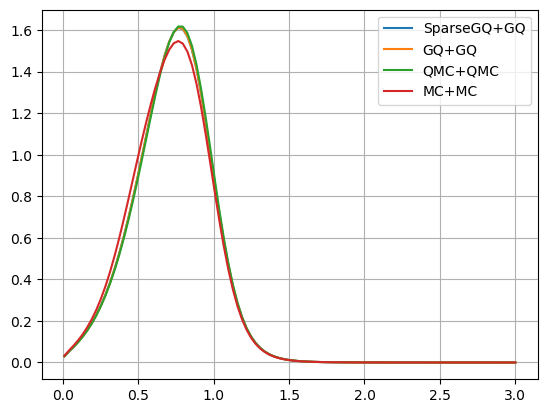

In [92]:
# see briefly the shape of pdf
xgrid = range(1e-2, stop=3, length=100)
plot(xgrid, pdf1.(xgrid), label = "SparseGQ+GQ")
plot(xgrid, pdf2.(xgrid), label = "GQ+GQ")
plot(xgrid, pdf3.(xgrid), label = "QMC+QMC")
plot(xgrid, pdf4.(xgrid), label = "MC+MC")
PyPlot.legend()
PyPlot.grid()

In [93]:
px=.6
quant1, err_quant1, quant_bound1 = quantile(cdf1, quantbound1, support1; p=px)
median1, err_med1, med_bound1 =  quantile(cdf1, quantbound1, support1)
mode1 = mode(pdf1, support1)
CI1, wp1, err_CI1 = credible_interval(cdf1, quantbound1, support1;
                                mode=:equal, wp=.95)

quant2, err_quant2, quant_bound2 = quantile(cdf2, quantbound2, support2; p=px)
median2, err_med2, med_bound2 =  quantile(cdf2, quantbound2, support2)
mode2 = mode(pdf2, support2)
CI2, wp2, err_CI2 = credible_interval(cdf2, quantbound2, support2;
                                mode=:equal, wp=.95)

quant3, err_quant3, quant_bound3 = quantile(cdf3, quantbound3, support3; p=px)
median3, err_med3, med_bound3 =  quantile(cdf3, quantbound3, support3)
mode3 = mode(pdf3, support3)
CI3, wp3, err_CI3 = credible_interval(cdf3, quantbound3, support3;
                                mode=:equal, wp=.95)

quant4, err_quant4, quant_bound4 = quantile(cdf4, quantbound4, support4; p=px)
median4, err_med4, med_bound4 =  quantile(cdf4, quantbound4, support4)
mode4 = mode(pdf4, support4)
CI4, wp4, err_CI4 = credible_interval(cdf4, quantbound4, support4;
                                mode=:equal, wp=.95)

println("Summary:")
println("            Median   Mode     $px quantile    Credible Intervel")
println("Sparse+GQ   $(@sprintf("%.5f", median1))  $(@sprintf("%.5f", mode1))  $(@sprintf("%.5f", quant1))         [$(@sprintf("%.4f", CI1[1])), $(@sprintf("%.4f", CI1[2]))] ")
println("GQ+GQ       $(@sprintf("%.5f", median2))  $(@sprintf("%.5f", mode2))  $(@sprintf("%.5f", quant2))         [$(@sprintf("%.4f", CI2[1])), $(@sprintf("%.4f", CI1[2]))]")
println("QMC+QMC     $(@sprintf("%.5f", median3))  $(@sprintf("%.5f", mode3))  $(@sprintf("%.5f", quant3))         [$(@sprintf("%.4f", CI3[1])), $(@sprintf("%.4f", CI1[2]))]")
println("MC+MC       $(@sprintf("%.5f", median4))  $(@sprintf("%.5f", mode4))  $(@sprintf("%.5f", quant4))         [$(@sprintf("%.4f", CI4[1])), $(@sprintf("%.4f", CI1[2]))]")
println("Credible level: $wp1")

┌ Warning: Can't compute 95% credible intervel, do 90% instead.
└ @ Main /home/xz584/projects/btg/BayesTransformedGaussian/src/statistics.jl:103
┌ Warning: Can't compute 95% credible intervel, do 90% instead.
└ @ Main /home/xz584/projects/btg/BayesTransformedGaussian/src/statistics.jl:103
┌ Warning: Can't compute 95% credible intervel, do 90% instead.
└ @ Main /home/xz584/projects/btg/BayesTransformedGaussian/src/statistics.jl:103
┌ Warning: Can't compute 95% credible intervel, do 90% instead.
└ @ Main /home/xz584/projects/btg/BayesTransformedGaussian/src/statistics.jl:103


Summary:
            Median   Mode     0.6 quantile    Credible Intervel
Sparse+GQ   0.72717  0.77417  0.78953         [0.1429, 1.1043] 
GQ+GQ       0.72750  0.77480  0.78982         [0.1431, 1.1043]
QMC+QMC     0.73143  0.77960  0.79348         [0.1552, 1.1043]
MC+MC       0.73143  0.77960  0.79348         [0.1534, 1.1043]
Credible level: 0.9


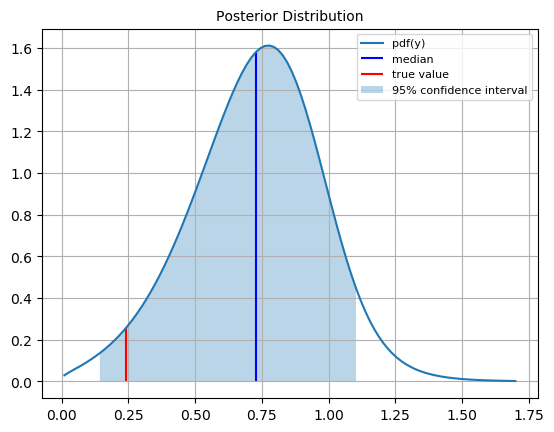

PyObject Text(0.5, 1, 'Posterior Distribution')

In [95]:
# plot all results
plot_distribution(pdf1, median1, y0_true; CI = CI1)

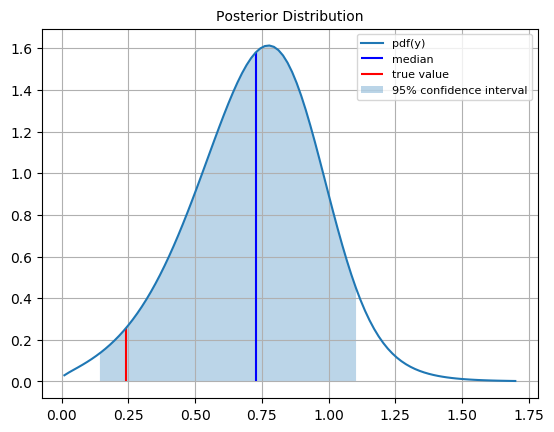

PyObject Text(0.5, 1, 'Posterior Distribution')

In [96]:
plot_distribution(pdf2, median2, y0_true; CI = CI2)

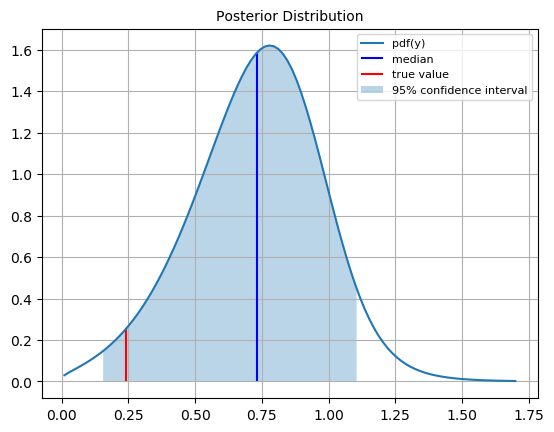

PyObject Text(0.5, 1, 'Posterior Distribution')

In [97]:
plot_distribution(pdf3, median3, y0_true; CI = CI3)

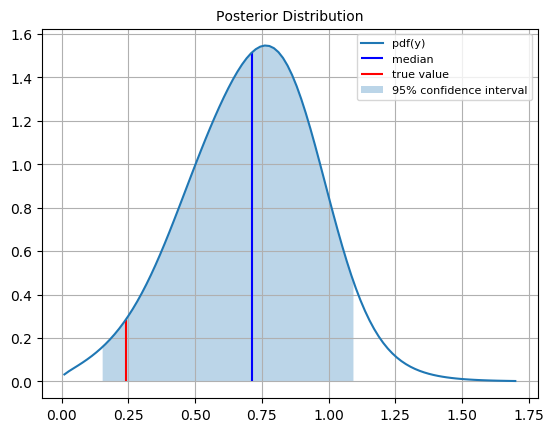

PyObject Text(0.5, 1, 'Posterior Distribution')

In [98]:
plot_distribution(pdf4, median4, y0_true; CI = CI4)